# Introduction

### This notebook focuses on detecting anomalies in financial markets using the XGBoost model and implementing an investment strategy based on the detected anomalies. The strategy uses key market indicators, such as price and moving averages, to generate buy, sell, or hold recommendations. Additionally, a chatbot is integrated to provide real-time insights and respond to user queries about the current strategy, anomalies, and market conditions.

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from flask import Flask, request, jsonify
import threading
from threading import Thread
import requests
import yfinance as yf

# Data Cleaning

In [92]:
dataset = pd.read_excel('../data/FinancialMarketData.xlsx', sheet_name='EWS' )

# moving averages   
dataset['VIX_moving_average'] = dataset['VIX'].rolling(window=7).mean()
dataset['BDIY_moving_average'] = dataset['BDIY'].rolling(window=7).mean()
dataset['CRY_moving_average'] = dataset['CRY'].rolling(window=7).mean()
dataset['Cl1_moving_average'] = dataset['Cl1'].rolling(window=7).mean()
dataset['USGG2YR_moving_average'] = dataset['USGG2YR'].rolling(window=7).mean()
dataset['GT10_moving_average'] = dataset['GT10'].rolling(window=7).mean()
dataset['DXY_moving_average'] = dataset['DXY'].rolling(window=7).mean()

# Ratios
dataset['DXY_to_VIX'] = dataset['DXY'] / dataset['VIX']

# Differences
dataset['VIX_diff'] = dataset['VIX'].diff()

dataset['Year'] = dataset['Data'].dt.year
dataset['Month'] = dataset['Data'].dt.month
dataset['Day'] = dataset['Data'].dt.day
dataset['DayOfWeek'] = dataset['Data'].dt.dayofweek

#correlation
correlation_matrix = dataset.corr()
low_cor_cols=correlation_matrix['Y'][abs(correlation_matrix['Y'])<0.04].index

#cleaning data
dataset_cleaned=dataset.drop(columns=low_cor_cols)

#Define Date as an Index
dataset.set_index('Data', inplace=True)

#droping Date Column
dataset_cleaned = dataset_cleaned.drop(columns=['Data'])

dataset_cleaned.describe()
print(dataset_cleaned.index)



RangeIndex(start=0, stop=1111, step=1)


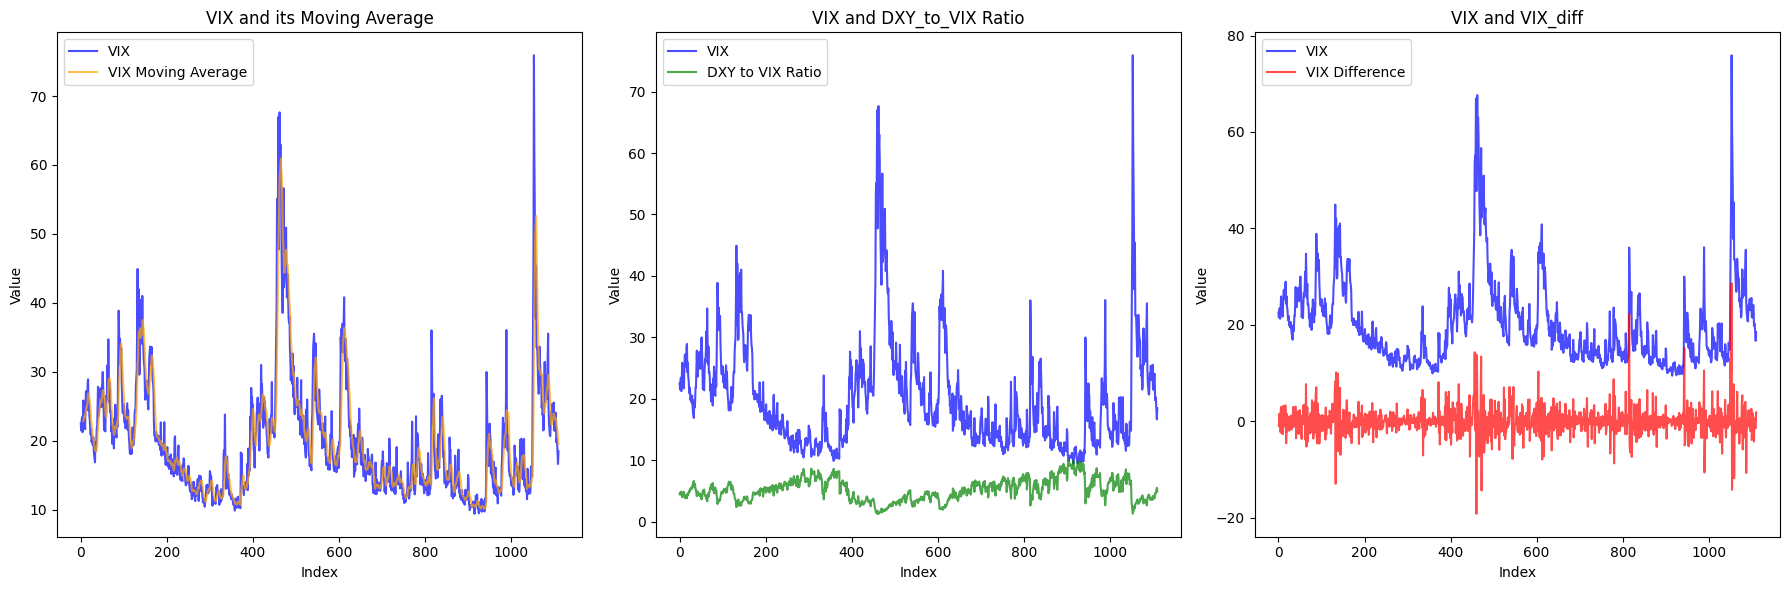

In [93]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Plot VIX and its Moving Average
axes[0].plot(dataset_cleaned['VIX'], label='VIX', alpha=0.7, color='blue')
axes[0].plot(dataset_cleaned['VIX_moving_average'], label='VIX Moving Average', alpha=0.7, color='orange')
axes[0].set_title("VIX and its Moving Average")
axes[0].set_xlabel("Index")
axes[0].set_ylabel("Value")
axes[0].legend()

# Plot VIX and its ratios (DXY_to_VIX)
axes[1].plot(dataset_cleaned['VIX'], label='VIX', alpha=0.7, color='blue')
axes[1].plot(dataset_cleaned['DXY_to_VIX'], label='DXY to VIX Ratio', alpha=0.7, color='green')
axes[1].set_title("VIX and DXY_to_VIX Ratio")
axes[1].set_xlabel("Index")
axes[1].set_ylabel("Value")
axes[1].legend()

# Plot VIX and its differences (VIX_diff)
axes[2].plot(dataset_cleaned['VIX'], label='VIX', alpha=0.7, color='blue')
axes[2].plot(dataset_cleaned['VIX_diff'], label='VIX Difference', alpha=0.7, color='red')
axes[2].set_title("VIX and VIX_diff")
axes[2].set_xlabel("Index")
axes[2].set_ylabel("Value")
axes[2].legend()

# Adjust spacing between plots
plt.tight_layout()

# Show the plots
plt.show()


# Data Preperation For Training

In [94]:
X= dataset_cleaned.drop(columns=['Y'])
y=dataset_cleaned['Y']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Model Training

## Handling Class Imbalance

In [95]:
class_counts = Counter(y_train)
negatives = class_counts[0]  # Normal class
positives = class_counts[1]  # Anomaly class

# Scale_pos_weight calcul
scale_pos_weight = negatives / positives
print(f"Scale Pos Weight: {scale_pos_weight}")


Scale Pos Weight: 3.649214659685864


## Training the XGBoost Classifier

In [96]:
# Model inisialization
model = XGBClassifier(
    n_estimators=200, 
    learning_rate=0.25, 
    random_state=43, 
    scale_pos_weight=5
)

model.fit(X_train, y_train)

#  prediction model
y_pred = model.predict(X_test)

print("Classification Report :")
print(classification_report(y_test, y_pred))


Classification Report :
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       177
           1       0.78      0.78      0.78        46

    accuracy                           0.91       223
   macro avg       0.86      0.86      0.86       223
weighted avg       0.91      0.91      0.91       223



# Investment Strategy Implementation

### In this section, we will define and implement a data-driven investment strategy based on the model's predictions.


In [97]:
dataset_cleaned['Anomaly'] = model.predict_proba(X)[:, 1] >= 0.1  
dataset_cleaned['price'] = dataset_cleaned['VIX']

position = 0  # Initial position (no active trade)
entry_price = None 

def define_strategy(row):
    global entry_price, position  # Using global variables to maintain state

    # Buy if conditions are met
    if row['Anomaly'] and row['VIX'] < row['VIX_moving_average']:
        if position == 0:  # Buy only if there is no active position
            entry_price = row['price']
            position = 1  # Active position
            return 'Buy'
    
    # Sell if conditions are met
    elif position > 0 and (row['price'] > entry_price * 1.1 or row['price'] < entry_price * 0.95):
        position = 0  # Close the position
        entry_price = None  # Reset entry price
        return 'Sell'
    
    # Do not trade on weekends
    elif row['DayOfWeek'] in [5, 6]:  # Assuming weekends are Saturday and Sunday
        return 'Hold'

    # Default action: hold
    return 'Hold'

# Strategy application
dataset_cleaned['Strategy'] = dataset_cleaned.apply(define_strategy, axis=1)


## Backtesting

In [98]:
# Initialization
initial_portfolio = 100000  # Initial capital
portfolio = initial_portfolio
position = 0  # Current position (amount of asset held)
entry_price = None  # Entry price for an active position
cash = initial_portfolio  # Uninvested cash amount
transaction_fee = 0.001  # Transaction fee (0.1% per transaction)

portfolio_values = []  # List to store portfolio values at each step
transactions = []  # List to log transactions

# Strategy simulation
for index, row in dataset_cleaned.iterrows():
    # Buy if the strategy indicates 'Buy' and no active position
    if row['Strategy'] == 'Buy' and position == 0:
        entry_price = row['price'] * (1 + transaction_fee)  # Include buy transaction fee
        position = cash / entry_price  # Calculate the amount bought
        cash = 0  # All cash is invested
        transactions.append(f"Buy at {row['price']} (adjusted: {entry_price}) on index {index}")
    
    # Sell if the strategy indicates 'Sell' and there is an active position
    elif row['Strategy'] == 'Sell' and position > 0:
        sell_price = row['price'] * (1 - transaction_fee)  # Include sell transaction fee
        cash = position * sell_price  # Calculate cash gained
        portfolio = cash  # Update portfolio value
        position = 0  # Reset the position
        transactions.append(f"Sell at {row['price']} (adjusted: {sell_price}) on index {index}")
    
    # Append the current portfolio value
    current_portfolio_value = cash + (position * row['price'] if position > 0 else 0)
    portfolio_values.append(current_portfolio_value)

# Calculate total return
total_return = (portfolio_values[-1] - initial_portfolio) / initial_portfolio * 100
print(f"Total Return: {total_return:.2f}%")

# Add the Portfolio_Value column to the dataset
dataset_cleaned['Portfolio_Value'] = portfolio_values

# Print the final portfolio value
print(f"Final Portfolio Value: {portfolio_values[-1]}")

# Print the transaction log
#print("\nTransactions:")
#for transaction in transactions:
   # print(transaction)




Total Return: 3294.45%
Final Portfolio Value: 3394445.949396071


##  Visualization Of The Portfolio

In [99]:
plt.figure(figsize=(20, 10))

# Plot SPY Index
plt.plot(dataset_cleaned['SPY'], label='SPY Index', alpha=0.7, color='blue')

# Plot Portfolio Value
plt.plot(dataset_cleaned['Portfolio_Value'], label="Portfolio Value", alpha=0.7, color='orange')

# Add Buy/Sell signals for SPY Index
plt.scatter(buy_signals.index, buy_signals['SPY'], color='green', label='Buy SPY', marker='^')
plt.scatter(sell_signals.index, sell_signals['SPY'], color='red', label='Sell SPY', marker='v')

# Add Buy/Sell signals for Portfolio Value
plt.scatter(buy_points, dataset_cleaned.loc[buy_points, 'Portfolio_Value'], color='lightgreen', label='Buy Portfolio', marker='^')
plt.scatter(sell_points, dataset_cleaned.loc[sell_points, 'Portfolio_Value'], color='lightcoral', label='Sell Portfolio', marker='v')

plt.title("SPY Index and Portfolio Value with Buy/Sell Signals")
plt.legend()
plt.show()


KeyError: 'SPY'

<Figure size 2000x1000 with 0 Axes>

# Chatbot

In [ ]:
app = Flask(__name__)

def get_current_strategy():
    # Retrieve the last row of the dataset , the last row corresponds to the information available at that precise moment(Real-time trading)
    current_row = dataset_cleaned.iloc[-1]  
    return current_row['Strategy'], current_row['price'], current_row['VIX_moving_average']


@app.route('/chat', methods=['POST'])
def chat():
    user_message = request.json.get('message', '').strip()
    response = ""

    # Handle empty messages
    if not user_message:
        return jsonify({'response': "Please enter a valid question or command."})

    # Get the current strategy and associated prices
    strategy, current_price, moving_average = get_current_strategy()

    # Logic based on the strategy
    if "buy" in user_message.lower():
        if strategy == "Buy":
            response = (f"The strategy recommends buying. "
                        f"The current price is {current_price}, which is below the moving average of {moving_average}.")
        else:
            response = "The current strategy does not recommend buying at the moment."
    elif "sell" in user_message.lower():
        if strategy == "Sell":
            response = (f"The strategy recommends selling. "
                        f"The current price is {current_price}. This meets the selling conditions.")
        else:
            response = "The current strategy does not recommend selling at the moment."
    elif "hold" in user_message.lower():
        if strategy == "Hold":
            response = "The strategy recommends holding your position for now."
        else:
            response = "There might be other opportunities in the market, but holding is not recommended."
    elif "anomaly" in user_message.lower():
        anomaly_count = dataset_cleaned['Anomaly'].sum()
        response = f"There are currently {anomaly_count} anomalies detected in the market."
    else:
        response = "I'm here to assist with questions about buying, selling, holding, or detecting anomalies."

    return jsonify({'response': response})


@app.route('/')
def index():
    return '''
<!DOCTYPE html>
<html>
<head>
    <title>Investment Strategy Chatbot</title>
    <link href="https://cdn.jsdelivr.net/npm/bootstrap@5.3.0-alpha1/dist/css/bootstrap.min.css" rel="stylesheet">
    <style>
        body {
            background-color: #f8f9fa;
            font-family: Arial, sans-serif;
        }
        .chat-container {
            max-width: 600px;
            margin: 50px auto;
            padding: 20px;
            background: white;
            border-radius: 10px;
            box-shadow: 0px 4px 12px rgba(0, 0, 0, 0.1);
            display: flex;
            flex-direction: column;
            height: 80vh;
        }
        #chat-box {
            flex-grow: 1;
            overflow-y: auto;
            padding: 10px;
            margin-bottom: 20px;
            border: 1px solid #ddd;
            border-radius: 8px;
            background-color: #f9f9f9;
        }
        .message {
            margin: 10px 0;
            display: flex;
            align-items: center;
        }
        .bot-message {
            background: #d1e7dd;
            padding: 10px;
            border-radius: 8px;
            max-width: 75%;
            display: inline-block;
        }
        .user-message {
            background: #f8d7da;
            padding: 10px;
            border-radius: 8px;
            max-width: 75%;
            text-align: right;
            margin-left: auto;
            display: inline-block;
        }
        .avatar {
            width: 30px;
            height: 30px;
            border-radius: 50%;
            margin-right: 10px;
        }
        .input-group {
            display: flex;
        }
        #message {
            flex-grow: 1;
            border-radius: 20px;
            padding: 10px;
            border: 1px solid #ced4da;
        }
        .btn {
            border-radius: 20px;
            margin-left: 10px;
        }
    </style>
</head>
<body>
    <div class="chat-container">
        <h1 class="text-center mb-3">Investment Strategy Chatbot</h1>
        <div id="chat-box"></div>
        <div class="input-group">
            <input type="text" id="message" class="form-control" placeholder="Ask me about buying, selling, or anomalies...">
            <button class="btn btn-primary" onclick="sendMessage()">Send</button>
        </div>
    </div>

    <script>
        async function sendMessage() {
            const userMessage = document.getElementById("message").value.trim();
            if (!userMessage) {
                alert("Please enter a message.");
                return;
            }

            const response = await fetch("/chat", {
                method: "POST",
                headers: { "Content-Type": "application/json" },
                body: JSON.stringify({ message: userMessage })
            });
            const data = await response.json();
            const chatBox = document.getElementById("chat-box");

            chatBox.innerHTML += `
                <div class="message user-message">
                    ${userMessage}
                </div>`;
            chatBox.innerHTML += `
                <div class="message bot-message">
                    <img src="https://via.placeholder.com/30" alt="Bot" class="avatar">
                    ${data.response}
                </div>`;
            
            document.getElementById("message").value = "";
            chatBox.scrollTop = chatBox.scrollHeight; // Auto scroll
        }
    </script>
</body>
</html>
    '''

def run_flask():
    # Run Flask application
    app.run(debug=True, port=5000, use_reloader=False)

# Start Flask server in a separate thread
if __name__ == '__main__':
    flask_thread = Thread(target=run_flask)
    flask_thread.start()
